In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/src")
)

In [2]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax
from time import perf_counter
from pymatching import Matching

from src.quantum_error_correction_code import SurfaceCode, deformation_cmap, relevancy_tensor
from src.neural_network import CNNDual, save_params, load_params
from src.perfect_maximum_likelihood_decoder import PMLD

In [3]:
BATCH_SIZE = 32
TRAINING_BATCHES = 1_000

CODE_DISTANCE = 3

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 2_000
TRANSITION_STEP = 50_000
DECAY_RATE = 0.95

# Number of filters, Kernal size, Stride
NUM_FILTERS = CODE_DISTANCE**2-1
CONV_LAYERS_INPUT_1 = [(NUM_FILTERS,2,1,0)]
CONV_LAYERS_INPUT_2 = [(NUM_FILTERS,1,1,0)]
CONV_LAYERS_STAGE_2 = [(NUM_FILTERS,2,1,0)]
FC_LAYERS = [50, 2]
print(f"{NUM_FILTERS = }")

SEED = 16

# NOTE: Train on a specific deformation or set to None to train on all deformations and find the best one

NAME = None

# Create a generalized decoder
# DEFORMATION = "Generalized"
# Find the best deformation
# DEFORMATION = "Best"
# Specific decoder to deformation
# DEFORMATION = "Specialize to best"

# No deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
# The XZZX deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[::2].set(3)
# The XY deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[:].set(2)
# The C1 deformation (extended)
# DEFORMATION = jnp.zeros((CODE_DISTANCE, CODE_DISTANCE), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2)
# Specific deformation
DEFORMATION, NAME = jnp.array([2, 2, 1, 3, 5, 4, 2, 1, 0], dtype=jnp.int32), "CNN-S-3-PD-PML"

p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
ERROR_PROB_TRAINING_SCALE = 2.0

settings = {
    "TRAINING_BATCHES": TRAINING_BATCHES,
    "BATCH_SIZE": BATCH_SIZE,
    "SEED": SEED,
    "INIT_LEARNING_RATE": INIT_LEARNING_RATE,
    "LEARNING_RATE": LEARNING_RATE,
    "WARMUP_STEPS": WARMUP_STEPS,
    "TRANSITION_STEP": TRANSITION_STEP,
    "DECAY_RATE": DECAY_RATE,
    "CODE_DISTANCE": CODE_DISTANCE,
    "ERROR_PROBS": ERROR_PROBS,
    "CONV_LAYERS_INPUT_1": CONV_LAYERS_INPUT_1,
    "CONV_LAYERS_INPUT_2": CONV_LAYERS_INPUT_2,
    "CONV_LAYERS_STAGE_2": CONV_LAYERS_STAGE_2,
    "FC_LAYERS": FC_LAYERS,
}

NUM_FILTERS = 8


In [4]:
save_data = True

if NAME is None:
    if DEFORMATION == "Best":
        NAME = f"CNN-P-{CODE_DISTANCE}"
    elif DEFORMATION == "Generalized":
        NAME = f"CNN-G-{CODE_DISTANCE}"
    elif DEFORMATION == "Specialize to best":
        NAME = f"CNN-P-{CODE_DISTANCE}-Specialized"
    elif isinstance(DEFORMATION, jnp.ndarray):
        NAME = f"CNN-S-{CODE_DISTANCE}-{''.join([str(d) for d in DEFORMATION])}"
    else:
        raise ValueError(f"Invalid DEFORMATION: {DEFORMATION}")

if DEFORMATION == "Best":
    _, pretrained_model_params = load_params(f"data/CNN-G-{CODE_DISTANCE}.json")
elif DEFORMATION == "Specialize to best":
    _, pretrained_model_params = load_params(f"data/CNN-P-{CODE_DISTANCE}.json")
    # Yes, it is intentional to overwrite the deformation
    DEFORMATION = nn.softmax(pretrained_model_params["deformation_dist"], axis=0).argmax(axis=0).flatten()
    print(DEFORMATION)
else:
    print("No pretrained model")
    pretrained_model_params = None

print(NAME)

No pretrained model
CNN-S-3-PD-PML


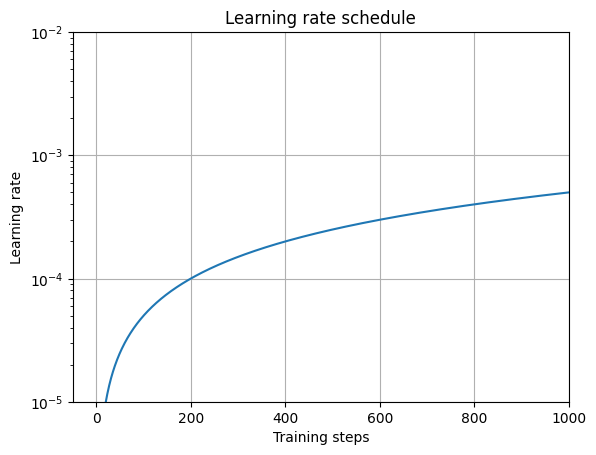

In [5]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.yscale('log')
plt.title("Learning rate schedule")
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim(xmax=TRAINING_BATCHES)
plt.ylim(1E-5, 1E-2)
plt.show()

optimizer = optax.adam(learning_rate)

In [6]:
def sample_deformation(
    key, 
    probs: jnp.ndarray
):
    """
    Samples a specific deformation based on a probability distribution on each data qubit.

    probs: Matrix of shape (6,*shape) with axis 0 summing to 1 in all cases

    return: Deformation array of size prod(*shape)
    """
    return _sample_deformation(key, probs)

@jit
def _sample_deformation(
    key, 
    probs: jnp.ndarray
):
    # Cumulative probability
    cp = jnp.cumsum(probs.reshape(6, -1), axis=0)
    # Random variable for sampling
    rv = random.uniform(key, shape=cp.shape[1])
    # Find the first index where the cumulative probability is greater than the random variable
    return (cp > rv).argmax(axis=0)

In [7]:
@jit
def sampled_deformations(
    deformation_key,
    probs: jnp.ndarray,
):
    deformation_keys = random.split(deformation_key, num=BATCH_SIZE+1)
    deformations = vmap(
        sample_deformation, 
        in_axes=(0, None)
    )(deformation_keys[1:], probs)
    return deformations, deformation_keys[0]

In [8]:
probs = jnp.ones(shape=(9, 6)) * jnp.array([0.0, 0.8, 0.0, 0.2, 0.0, 0.0])[None, :]
key = random.PRNGKey(0)
sample_deformation(key, probs)

Array([0, 2, 0, 4, 1, 0, 3, 0, 0], dtype=int32)

In [9]:
sample_deformation(key, probs)

Array([0, 2, 0, 4, 1, 0, 3, 0, 0], dtype=int32)

In [10]:
qec = SurfaceCode(3)
qec.random_deformation(key, probs)

(Array([3, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32),
 Array([ 928981903, 3453687069], dtype=uint32))

In [11]:
def train(
    random_seed: int,
    code: SurfaceCode,
    probabilities: jnp.ndarray,
    optimizer: optax.GradientTransformation,
    model: CNNDual,
    pretrained_model_params: dict | None = None,
):
    @jit
    def loss_fn(
        model_params,
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Loss function for the model. The loss is the binary cross entropy (BCE) between the
        model output and the logicals. The BCE is weighted by the probability of the deformation.
        """
        # Calculate the BCE
        idv_loss = optax.sigmoid_binary_cross_entropy(
            logits=model.apply_batch(model_params, x1, x2),
            labels=y
        ).mean(axis=1)
        # If DEFORMATION is set, we don't use weights
        # and just return the mean BCE
        if isinstance(DEFORMATION, jnp.ndarray) or DEFORMATION == "Generalized":
            return jnp.mean(idv_loss)
        # Calculate the weights for the BCE
        probs = nn.softmax(model_params["deformation_dist"], axis=0).reshape(6, -1).T[None, :, :]
        err_idx = (errors[:,0,:] + 2*errors[:,1,:])
        # The sum is over the deformation probabilities on the same data qubit
        # The prod is over the data qubits for the same batch
        weights = jnp.prod(jnp.sum(probs*relevancy_tensor[err_idx, deformations], axis=2), axis=1)
        # Weights are applied to the BCE
        # 1 is added to all weights in the scenario that they all sum to less than 0.01 as to avoid devision by 0
        return jnp.average(idv_loss, weights=weights + (weights.sum() < .01).astype(jnp.float32))

    @jit
    def update(
        model_params, 
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, deformations, errors, x1, x2, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
        deformations: jnp.ndarray,
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        parity_infos = vmap(
            code.deformation_parity_info
        )(deformations)
        errors = vmap(
            code.error,
            in_axes=(0, None),
        )(data_key[:-1], probabilities)
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, 0),
        )(errors, parity_infos)
        return imgs[:,None,:,:], logicals, errors, data_key[-1]

    @jit
    def sampled_deformations(
        deformation_key,
        probs: jnp.ndarray,
    ):
        deformation_keys = random.split(deformation_key, num=BATCH_SIZE)
        deformations, keys = vmap(
            qec.random_deformation, 
            in_axes=(0, None)
        )(deformation_keys, probs)
        return deformations, keys[0]

    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        ) = val

        # deformations shape=(BATCH_SIZE, NUM_DATA_QUBITS)
        if isinstance(DEFORMATION, jnp.ndarray):
            # If DEFORMATION is set, we only train on that deformation
            deformations = jnp.tile(DEFORMATION, reps=(BATCH_SIZE, 1))
        elif DEFORMATION == "Best":
            # Sample a deformation for each batch
            probs = nn.softmax(model_params["deformation_dist"], axis=0)
            deformations, deformation_key = sampled_deformations(deformation_key, probs)
        elif DEFORMATION == "Generalized":
            # Sample a deformation for each batch with uniform distribution
            probs = jnp.ones_like(model_params["deformation_dist"]) / 6
            (deformations, deformation_key) = sampled_deformations(deformation_key, probs)
        # deformation_images shape=(BATCH_SIZE, 6, CODE_DISTANCE, CODE_DISTANCE)
        deformation_images = vmap(code.deformation_image)(deformations)

        # syndrome_images shape=(BATCH_SIZE, 1, CODE_DISTANCE+1, CODE_DISTANCE+1)
        # logicals shape=(BATCH_SIZE, 2)
        syndrome_images, logicals, errors, data_key = get_data(
            data_key,
            deformations,
        )
        loss, model_params, opt_state = update(
            model_params,
            deformations,
            errors,
            syndrome_images,
            deformation_images,
            logicals,
            opt_state,
        )
        losses = losses.at[i].set(loss)
        # Recentering the deformation distribution to avoid numerical issues (the softmax function is invariant to additive constants)
        model_params["deformation_dist"] = model_params["deformation_dist"] - model_params["deformation_dist"].mean(axis=0)

        return (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        )
    
    init_key, data_key, deformation_key = random.split(
        key = random.key(random_seed),
        num=3
    )
    num_itr = TRAINING_BATCHES

    if pretrained_model_params is None:
        # Initialize the model parameters
        model_params = model.init(init_key)
    else:
        # Copy the model parameters
        model_params = pretrained_model_params.copy()
    # The deformation distribution is initialized to be uniform over all deformations
    if isinstance(DEFORMATION, jnp.ndarray):
        # If DEFORMATION is set, we only train on that deformation
        model_params["deformation_dist"] = 1000*(code.deformation_image(DEFORMATION) - .5)
    else:
        # If DEFORMATION is not set, we train on all deformations
        # and the deformation distribution is initialized to be uniform over all deformations
        model_params["deformation_dist"] = jnp.zeros(
            shape=(6, CODE_DISTANCE, CODE_DISTANCE),
            dtype=jnp.float32
        )
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=num_itr, dtype=jnp.float32)

    val_init = (
        model_params,
        optimizer_state,
        data_key,
        deformation_key,
        losses,
    )

    vals = lax.fori_loop(0, num_itr, _fori_body, val_init)

    return vals

In [13]:
code = SurfaceCode(L=CODE_DISTANCE)
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
print("Model architecture:")
for name, layer_sizes in model.layer_sizes.items():
    print("\t", name, layer_sizes)

t0 = perf_counter()

(
    model_params,
    opt_state,
    data_key,
    deformation_key,
    losses,
) = train(
    random_seed=SEED,
    code=code,
    probabilities=ERROR_PROBS*ERROR_PROB_TRAINING_SCALE,
    optimizer=optimizer,
    model=model,
    pretrained_model_params=pretrained_model_params,
)

if save_data:
    save_params(
        model_params,
        settings,
        f"../results/trained-models/{NAME}.json"
    )
    jnp.save(
        f"../results/raw-data/loss_{NAME}.npy",
        losses,
    )
    print("\nSaved data under ../results/ with name:", NAME)

training_time = perf_counter() - t0
print(f"\nTraining took {int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

Model architecture:
	 CNN_input_1 [(1, 4, 4), (8, 3, 3)]
	 CNN_input_2 [(6, 3, 3), (8, 3, 3)]
	 CNN_stage_2 [(8, 3, 3), (8, 2, 2)]
	 MLP_stage_3 [32, 50, 2]

Saved data under ../results/ with name: CNN-S-3-PD-PML

